## Robustness check

In order to assess the robustness of the results derived in sell_all_portfolio_simulation.ipynb, this notebook is implemented.   
Over a span of xxx years, xxx companies will be randomly drawn and a Portfolio simulationg following the LLM recommendations, as well as the
analyst recommendations will be run. The simulations' results will be collected and compared to enable a robust check of the previously obtained results.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.faster_portfolio_simulation_class import PortfolioSimulation_fast
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from joblib import Parallel, delayed

In [2]:
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})
# Risk free rate df
risk_free_rate_df = pd.read_csv("../data/us3mt_yield_curve.csv")

- Reading in recommendations

In [3]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
analyst_ratings.head()

,cik,date,mean_rating,rating,security,action
0,0000001750,2000-01,1.71429,buy,AAR CORP.,buy
1,0000001750,2000-02,1.71429,buy,AAR CORP.,buy
2,0000001750,2000-03,1.71429,buy,AAR CORP.,buy
3,0000001750,2000-04,1.50000,strong buy,AAR CORP.,buy
4,0000001750,2000-05,1.50000,strong buy,AAR CORP.,buy


In [4]:
# LLM recommendations with only most recent financial statements
llm_recommendations1 = pd.read_csv("../data/ciklist1_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations2 = pd.read_csv("../data/ciklist2_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations3 = pd.read_csv("../data/ciklist3_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations4 = pd.read_csv("../data/missing_ratings.csv", dtype={"cik": str})

# Combine into one DataFrame
llm_recommendations = pd.concat([llm_recommendations1, llm_recommendations2, llm_recommendations3, llm_recommendations4], ignore_index=True)
llm_recommendations.head()

,cik,date,rating
0,0001497645,2010-03-31,sell
1,0001497645,2010-06-30,sell
2,0001497645,2010-09-30,sell
3,0001497645,2010-12-31,sell
4,0001497645,2011-03-31,sell


---
### Preprocessing

- Copied function to preprocess signals

In [5]:
def extract_signal(text):
    # Normalize text: lowercase, remove punctuation, remove extra spaces
    text_clean = ''.join(c for c in text.lower())
    
    # Map strong signals to regular ones
    if 'strong buy' in text_clean:
        return 'buy'
    if 'strong sell' in text_clean:
        return 'sell'
    if 'buy' in text_clean:
        return 'buy'
    if 'sell' in text_clean:
        return 'sell'
    if 'hold' in text_clean:
        return 'hold'
    return None  


In [6]:
 # Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)

In [7]:
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)

# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)

len(llm_recommendations), len(analyst_ratings)

(120860, 355218)

In [8]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates() # drop duplicates may be double, but just to be safe

# Determine overlap through merge
shared_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

# Determine unique ciks, dates and min/max year
ciks = shared_ciks_and_dates["cik"].unique()
dates = shared_ciks_and_dates["date"].unique()
min_period = pd.to_datetime(dates).to_period("M").min()
max_period = pd.to_datetime(dates).to_period("M").max()

In [9]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, shared_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, shared_ciks_and_dates, on=["cik", "date"], how="inner"
)

# Construct "temp"-date column still as period for filtering later on
llm_recommendations_final["date_tmp"] = pd.to_datetime(llm_recommendations_final["date"]).dt.to_period("M")
analyst_ratings_final["date_tmp"] = pd.to_datetime(analyst_ratings_final["date"]).dt.to_period("M")

# Check format
len(llm_recommendations_final), len(analyst_ratings_final)

(113301, 113301)

---
### Actual robustness check

In [10]:
# Number of companies to draw
sample_size = 750
# Number of months to regard
timespan = 120
# Number of simulations
iterations = 1000
# Set seed base for reproducibility (increase by a 1000 for each new simulation - just to be safe)
seed_base = 4001

In [11]:
def run_single_simulation(i, dates, timespan,
                          llm_recommendations_final, analyst_ratings_final,
                          stock_prices, risk_free_rate_df, PortfolioSimulation_fast, seed_base = 42):
    
    # Set seed for reproducibility
    rng = np.random.default_rng(seed_base + i)
    # Convert dates to periods
    periods = pd.to_datetime(dates).to_period("M")

    # Valid start dates
    valid_starts = [p for p in periods if p + timespan <= periods.max()]
    robustness_start = rng.choice(valid_starts)
    robustness_end = robustness_start + timespan

    # Filter recommendation dfs for valid dates
    llm_recommendations_simulation = llm_recommendations_final[
        (llm_recommendations_final["date_tmp"] >= robustness_start) &
        (llm_recommendations_final["date_tmp"] <= robustness_end)
    ].drop(columns="date_tmp")

    analyst_ratings_simulation = analyst_ratings_final[
        (analyst_ratings_final["date_tmp"] >= robustness_start) &
        (analyst_ratings_final["date_tmp"] <= robustness_end)
    ].drop(columns="date_tmp")

    # Random selection of CIKs (List has to be sorted, because set is non-deterministic in order, only look 1 hour to find this out..)
    common_ciks = sorted(set(llm_recommendations_simulation["cik"]).intersection(set(analyst_ratings_simulation["cik"])))
    robustness_ciks = rng.choice(list(common_ciks), size=sample_size, replace=False)

    # Filter both dfs for valid CIKs
    llm_recommendations_simulation = llm_recommendations_simulation[
        llm_recommendations_simulation["cik"].isin(robustness_ciks)
    ]
    analyst_ratings_simulation = analyst_ratings_simulation[
        analyst_ratings_simulation["cik"].isin(robustness_ciks)
    ]

    # Start capital for both simulations
    # This is actually not too important, as purchasing partial shares is enabled.
    # The results i.e. actual number of stocks etc. are however better interpretable with a higher start capital.
    start_capital = 1000000

    # Run LLM simulation
    llm_sim = PortfolioSimulation_fast(initial_capital=start_capital)
    llm_sim.partial_shares = True
    llm_sim.load_dataframes(stock_prices, llm_recommendations_simulation, risk_free_rate_df)
    llm_sim.simulate_trading()
    llm_returns = llm_sim.calculate_monthly_returns()
    llm_stats = llm_sim.portfolio_statistics(monthly_returns=llm_returns)

    # Run Analyst simulation
    analyst_sim = PortfolioSimulation_fast(initial_capital=start_capital)
    analyst_sim.partial_shares = True
    analyst_sim.load_dataframes(stock_prices, analyst_ratings_simulation, risk_free_rate_df)
    analyst_sim.simulate_trading()
    analyst_returns = analyst_sim.calculate_monthly_returns()
    analyst_stats = analyst_sim.portfolio_statistics(monthly_returns=analyst_returns)

    return {
        "simulation": i + 1,
        "no_companies": analyst_ratings_simulation["cik"].nunique(),
        "start_date": robustness_start,
        "end_date": robustness_end,
        "llm_sr": llm_stats["Annualized Sharpe Ratio"],
        "llm_mean_ret": llm_stats["Annualized mean return"],
        "llm_final_val": llm_stats["Final Portfolio value (normalized)"],
        "analyst_sr": analyst_stats["Annualized Sharpe Ratio"],
        "analyst_mean_ret": analyst_stats["Annualized mean return"],
        "analyst_final_val": analyst_stats["Final Portfolio value (normalized)"],
        "companies": robustness_ciks.tolist()
    }

In [12]:
# --- Run in parallel ---
robustness_results = Parallel(n_jobs=10, verbose=10)(
    delayed(run_single_simulation)( # what delayed does is prevent the function from being executed immediately, instead it creates a task that can be executed later in parallel
        i, dates, timespan,
        llm_recommendations_final, analyst_ratings_final,
        stock_prices, risk_free_rate_df, PortfolioSimulation_fast, seed_base=seed_base
    )
    for i in range(iterations)
)
# Construct DataFrame
robustness_results_df = pd.DataFrame(robustness_results)

# Save results to CSV
robustness_results_df.to_csv(f"../data/robustness_check_results_parallelized_timespan{timespan}_sample{sample_size}_iterations{iterations}_seed{seed_base}.csv", index=False)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 35.3min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 69.6min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 103.7min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 110.2min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 172.6min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 210.6min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 239.5min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 271.5min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed: 322.9min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 357.4min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed: 410.8min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 463.1min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed: 517.3min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 558.0min
[Parallel(n_jobs=10)]: Done 201 tasks      

In [17]:
robustness_results_df

,simulation,no_companies,start_date,end_date,llm_sr,llm_mean_ret,llm_final_val,analyst_sr,analyst_mean_ret,analyst_final_val,companies
0,1,750,2003-07,2013-07,1.241057,0.272069,11.094507,0.855992,0.176184,5.067016,"[0001327811, 0001120193, 0001046257, 000121254..."
1,2,750,2001-06,2011-06,0.984993,0.227186,7.746477,0.639080,0.136276,3.587868,"[0001120193, 0000016058, 0001032033, 000104610..."
2,3,750,2002-06,2012-06,1.186214,0.269410,10.864715,0.808571,0.170912,4.844414,"[0000019617, 0000728535, 0000899751, 000104204..."
3,4,750,2006-10,2016-10,1.163339,0.234088,8.193347,0.886387,0.173731,4.962336,"[0000795266, 0001331520, 0001405495, 000085196..."
4,5,750,2014-05,2024-05,1.131210,0.234630,8.229409,0.866535,0.180409,5.252015,"[0001672013, 0000004977, 0001682852, 000175626..."
...,...,...,...,...,...,...,...,...,...,...,...
995,996,750,2009-07,2019-07,1.541832,0.270061,10.920545,1.268907,0.219494,7.274389,"[0001600438, 0001490906, 0001576018, 000103598..."
996,997,750,2007-07,2017-07,1.030653,0.227442,7.762640,0.832012,0.160745,4.439850,"[0000811596, 0000906107, 0000089089, 000086073..."
997,998,750,2007-03,2017-03,1.141227,0.235574,8.292539,0.827676,0.158604,4.358638,"[0000034903, 0001526520, 0001047335, 000005072..."
998,999,750,2004-10,2014-10,1.333364,0.291668,12.927381,0.919472,0.187713,5.586192,"[0001039684, 0001996862, 0000887936, 000110924..."


In [11]:
robustness_results_df_50 = pd.read_csv("../data/robustness_check_results_parallelized_timespan120_sample50_iterations1000_seed1.csv")
robustness_results_df_100 = pd.read_csv("../data/robustness_check_results_parallelized_timespan120_sample100_iterations1000_seed1001.csv")
robustness_results_df_250 = pd.read_csv("../data/robustness_check_results_parallelized_timespan120_sample250_iterations1000_seed2001.csv")
robustness_results_df_500 = pd.read_csv("../data/robustness_check_results_parallelized_timespan120_sample500_iterations1000_seed3001.csv")
robustness_results_df_750 = pd.read_csv("../data/robustness_check_results_parallelized_timespan120_sample750_iterations1000_seed4001.csv")
robustness_results_df = pd.concat([robustness_results_df_50, robustness_results_df_100, robustness_results_df_250, robustness_results_df_500, robustness_results_df_750], ignore_index=True)
robustness_results_df

,simulation,no_companies,start_date,end_date,llm_sr,llm_mean_ret,llm_final_val,analyst_sr,analyst_mean_ret,analyst_final_val,companies
0,1,50,2014-08,2024-08,0.788056,0.197094,6.043440,0.732531,0.189196,5.656342,"['0001420800', '0001699150', '0000825542', '00..."
1,2,50,2011-08,2021-08,0.835363,0.164576,4.588569,1.029264,0.191155,5.750191,"['0000785161', '0001639300', '0000820313', '00..."
2,3,50,2010-05,2020-05,1.064217,0.192461,5.813543,0.820800,0.162315,4.500280,"['0000002488', '0000919012', '0001674862', '00..."
3,4,50,2001-07,2011-07,0.366192,0.081033,2.179669,0.315085,0.066354,1.901131,"['0000850209', '0000866706', '0001324424', '00..."
4,5,50,2004-10,2014-10,1.133942,0.231541,8.025809,0.600192,0.133540,3.502422,"['0000093556', '0000899923', '0001573516', '00..."
...,...,...,...,...,...,...,...,...,...,...,...
4995,996,750,2009-07,2019-07,1.541832,0.270061,10.920545,1.268907,0.219494,7.274389,"['0001600438', '0001490906', '0001576018', '00..."
4996,997,750,2007-07,2017-07,1.030653,0.227442,7.762640,0.832012,0.160745,4.439850,"['0000811596', '0000906107', '0000089089', '00..."
4997,998,750,2007-03,2017-03,1.141227,0.235574,8.292539,0.827676,0.158604,4.358638,"['0000034903', '0001526520', '0001047335', '00..."
4998,999,750,2004-10,2014-10,1.333364,0.291668,12.927381,0.919472,0.187713,5.586192,"['0001039684', '0001996862', '0000887936', '00..."


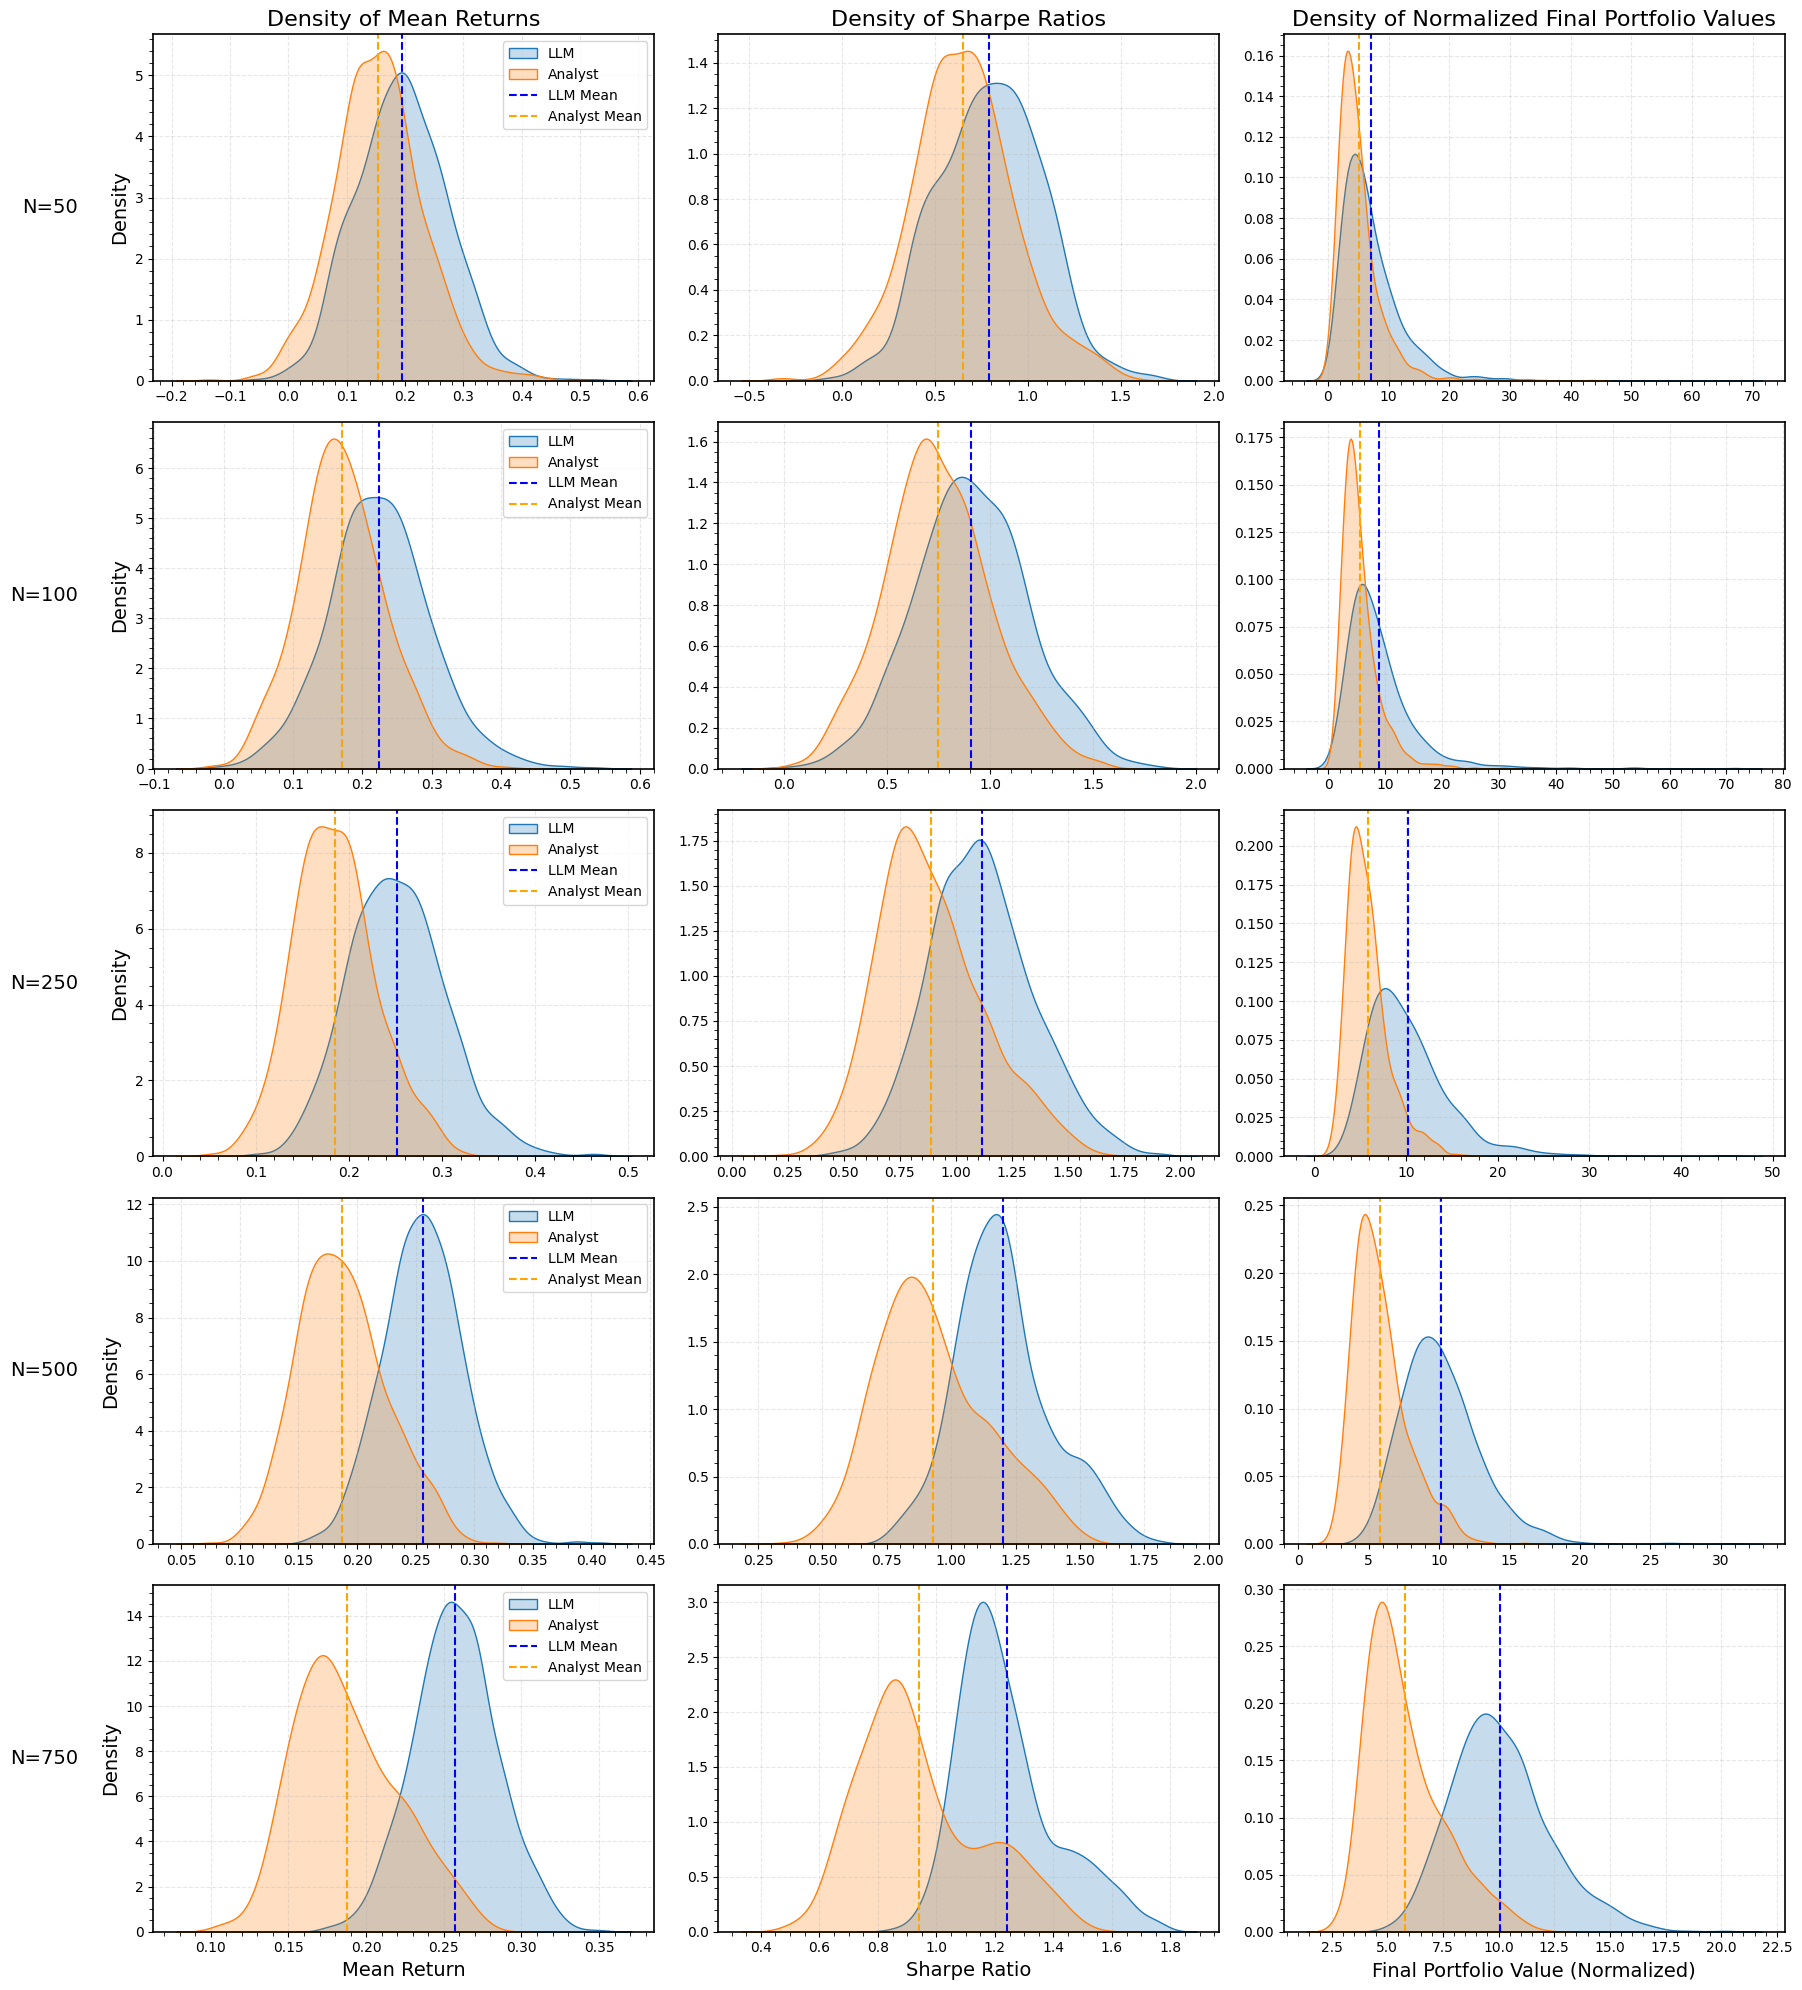

In [ ]:
# Dict of dataframes with sample size labels
dfs = {
    "N=50": robustness_results_df_50,
    "N=100": robustness_results_df_100,
    "N=250": robustness_results_df_250,
    "N=500": robustness_results_df_500,
    "N=750": robustness_results_df_750
}

# Variables to plot: (llm_col, analyst_col, title, xlabel)
variables = [
    ("llm_mean_ret", "analyst_mean_ret", "Density of Mean Returns", "Mean Return"),
    ("llm_sr", "analyst_sr", "Density of Sharpe Ratios", "Sharpe Ratio"),
    ("llm_final_val", "analyst_final_val", "Density of Normalized Final Portfolio Values", "Final Portfolio Value (Normalized)")
]

fig, axes = plt.subplots(len(dfs), len(variables), figsize=(18, 20))

# Loop through rows and columns
for row, (df_label, df) in enumerate(dfs.items()):
    for col, (llm_col, analyst_col, title, xlabel) in enumerate(variables):
        ax = axes[row, col]
        
        # KDE plots
        sns.kdeplot(df[llm_col], label="LLM", fill=True, ax=ax)
        sns.kdeplot(df[analyst_col], label="Analyst", fill=True, ax=ax)

        # Vertical mean lines
        ax.axvline(df[llm_col].mean(), color="blue", linestyle="--", label="LLM Mean")
        ax.axvline(df[analyst_col].mean(), color="orange", linestyle="--", label="Analyst Mean")

        # Titles only on top row
        if row == 0:
            ax.set_title(title, fontsize=16)

        # Y-axis label and sample size as row annotation
        if col == 0:
            ax.set_ylabel("Density", fontsize=14)
            ax.text(-0.15, 0.5, df_label, va='center', ha='right',
                    rotation=0, transform=ax.transAxes, fontsize=14)
        else:
            ax.set_ylabel("")

        # X-axis label only on bottom row
        if row == len(dfs)-1: # although python is 0-indexed, len gives the actual count
            ax.set_xlabel(xlabel, fontsize = 14)
        else:
            ax.set_xlabel("")

        # Legend only in first column
        if col == 0:
            ax.legend(loc="upper right", fontsize=10)

        # Minor ticks
        ax.minorticks_on()
        ax.tick_params(which='minor', length=3)

        # Table-style borders
        # Draw top and bottom borders for each row
        ax.spines['top'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)
        # Draw left and right borders for each column
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['right'].set_linewidth(1.2)
        # Optional: add subtle gridlines inside each subplot
        ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout() # tight layout just somehow optimizes the spacing overall (?)
plt.savefig("../figures/robustness_check_all_sample_sizes.png", dpi=300)
plt.show()

---
### Computing p-values

The underlying Hypothesis is:

##### - H_0: The returns generated by following the LLM portfolio strategy are smaller or equal to the returns generated by the Analysts' strategy:   r_pf <= r_a

Consequently, the Alternate Hypothesis is:
##### - H_1: The returns generated by following the LLM portfolio strategy are larger than the ones generated by the Analysts' strategy.

Therefore, this represents a one-sided test.

Remarks:
- If t_stat is positive, means of first group is larger than means of second group, i.e. llm_ret > analyst_ret
- P-value then needs to be divided by two to account for one-sided test

- If t_stat was negative, this would be reversed

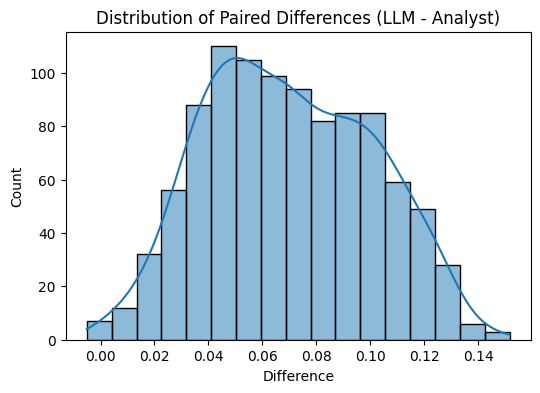

Shapiro-Wilk p-value: 0.0000
Wilcoxon paired test p-value: 0.0000


In [100]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Compute paired differences
diffs = robustness_results_df_750["llm_mean_ret"] - robustness_results_df_750["analyst_mean_ret"]

# 1️⃣ Visual check: histogram & KDE
plt.figure(figsize=(6,4))
sns.histplot(diffs, kde=True)
plt.title("Distribution of Paired Differences (LLM - Analyst)")
plt.xlabel("Difference")
plt.show()

# 2️⃣ Statistical normality tests
shapiro_stat, shapiro_p = stats.shapiro(diffs)  # Shapiro-Wilk test
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f}")

# Interpretation:
# p > 0.05 → fail to reject normality (ok to use t-test)
# p < 0.05 → reject normality (consider non-parametric test)

# 3️⃣ If normality is violated, use non-parametric Wilcoxon test
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(
    robustness_results_df_750["llm_mean_ret"],
    robustness_results_df_750["analyst_mean_ret"]
)
print(f"Wilcoxon paired test p-value: {wilcoxon_p:.4f}")


In [ ]:
def compute_p_value(llm_returns_df, analyst_returns_df):
    from scipy import stats
    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(llm_returns_df["llm_mean_ret"], analyst_returns_df["analyst_mean_ret"])
    # Since this is a one-sided test, divide p-value by 2
    if t_stat > 0: # if t_stat is positive, it means llm_mean_ret > analyst_mean_ret
        p_value /= 2
    else:
        p_value = 1 - (p_value / 2)
    return t_stat, p_value

In [89]:
# P-value for sample size N = 50
import scipy.stats as stats
llm_50_ret = robustness_results_df_50["llm_mean_ret"].mean()
analyst_50_ret = robustness_results_df_50["analyst_mean_ret"].mean()
print(f"N = 50: LLM Mean Return: {llm_50_ret*100:.2f}%, Analyst Mean Return: {analyst_50_ret*100:.2f}%")

# Perform t-test
t_stat_50, p_value_50 = compute_p_value(robustness_results_df_50, robustness_results_df_50)
p_value_50

N = 50: LLM Mean Return: 19.41%, Analyst Mean Return: 15.43%


np.float64(3.623335435403785e-46)

In [91]:
# P-value for sample size N = 100
llm_100_ret = robustness_results_df_100["llm_mean_ret"].mean()
analyst_100_ret = robustness_results_df_100["analyst_mean_ret"].mean()
print(f"N = 100: LLM Mean Return: {llm_100_ret*100:.2f}%, Analyst Mean Return: {analyst_100_ret*100:.2f}%")
# Perform t-test
t_stat_100, p_value_100 = compute_p_value(robustness_results_df_100, robustness_results_df_100)
p_value_100

N = 100: LLM Mean Return: 22.46%, Analyst Mean Return: 17.09%


np.float64(2.536215890750329e-94)

In [92]:
# P-value for sample size N = 250
llm_250_ret = robustness_results_df_250["llm_mean_ret"].mean()
analyst_250_ret = robustness_results_df_250["analyst_mean_ret"].mean()
print(f"N = 250: LLM Mean Return: {llm_250_ret*100:.2f}%, Analyst Mean Return: {analyst_250_ret*100:.2f}%")
# Perform t-test
t_stat_250, p_value_250 = compute_p_value(robustness_results_df_250, robustness_results_df_250)
p_value_250

N = 250: LLM Mean Return: 25.15%, Analyst Mean Return: 18.49%


np.float64(1.1599698181159866e-210)

In [93]:
# P-value for sample size N = 500
llm_500_ret = robustness_results_df_500["llm_mean_ret"].mean()
analyst_500_ret = robustness_results_df_500["analyst_mean_ret"].mean()
print(f"N = 500: LLM Mean Return: {llm_500_ret*100:.2f}%, Analyst Mean Return: {analyst_500_ret*100:.2f}%")
# Perform t-test
t_stat_500, p_value_500 = compute_p_value(robustness_results_df_500, robustness_results_df_500)
p_value_500

N = 500: LLM Mean Return: 25.64%, Analyst Mean Return: 18.74%


np.float64(1.22e-321)

In [94]:
# P-value for sample size N = 750
llm_750_ret = robustness_results_df_750["llm_mean_ret"].mean()
analyst_750_ret = robustness_results_df_750["analyst_mean_ret"].mean()
print(f"N = 750: LLM Mean Return: {llm_750_ret*100:.2f}%, Analyst Mean Return: {analyst_750_ret*100:.2f}%")
# Perform t-test
t_stat_750, p_value_750 = compute_p_value(robustness_results_df_750, robustness_results_df_750)
p_value_750

N = 750: LLM Mean Return: 25.73%, Analyst Mean Return: 18.76%


np.float64(0.0)

In [101]:
# 3️⃣ If normality is violated, use non-parametric Wilcoxon test
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(
    robustness_results_df_750["llm_mean_ret"],
    robustness_results_df_750["analyst_mean_ret"]
)
print(f"Wilcoxon paired test p-value: {wilcoxon_p:.4f}")

Wilcoxon paired test p-value: 0.0000



- Returns seem to me more or less stable after sample size 250